In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import contextily as ctx
import scipy.stats as stats
from shapely import Point

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')
dbi = gpd.read_feather('../data/dbi_permits.geofeather')
fees = gpd.read_file('../data/Neighborhood-Specific Impact Fee Areas.geojson')

## Fees

In [3]:
fees.loc[fees.tier.str.contains('Tier 1 if residential') == True, 'tier'] = 'Tier 1'
simplefees = fees[fees.tier.isin(['Tier 1', 'Tier 2'])] # , 'Tier 3'
simplefees = simplefees.dissolve('tier').reset_index()
simplefees = simplefees.to_crs(3310)
x_min, y_min, x_max, y_max = simplefees.total_bounds

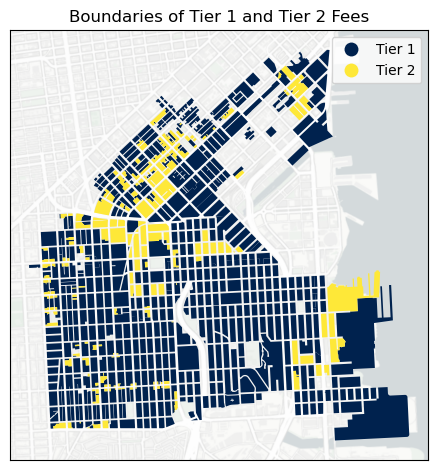

In [5]:
ax = simplefees.plot(column='tier', legend=True, cmap='cividis')
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=3310)
ax.set_title('Boundaries of Tier 1 and Tier 2 Fees')
plt.tight_layout()
plt.savefig('tier1_tier2_boundaries.png')

## Permits

In [6]:
panel = gpd.read_feather('../data/basic_panel_with_slopes_lags.geofeather')

In [7]:
panel = panel.cx[x_min:x_max, y_min:y_max]

In [8]:
cross_section = panel[panel.year == 2014]

In [9]:
y = panel[panel.year >= 2014].groupby("MapBlkLot_Master")['Net_Units_Completed'].sum()

In [10]:
cross_section = pd.merge(cross_section.drop(columns='Net_Units_Completed'),
                         y.reset_index(),
                         on='MapBlkLot_Master')

In [11]:
cross_section.Net_Units_Completed.sum()

7153.0

In [12]:
cross_section = cross_section.drop(columns=['mapblklot', 'permit_number', 'year'])

In [13]:
cross_section['tier1'] = cross_section.geometry.intersects(simplefees.iloc[0].geometry)
cross_section['tier2'] = cross_section.geometry.intersects(simplefees.iloc[1].geometry)

## Take the subset of the data where there are fees

In [74]:
east_homes = cross_section[(cross_section['tier1'] ^ cross_section['tier2'])].copy()
east_homes['tier'] = 'tier2'
east_homes.loc[east_homes['tier1'], 'tier'] = 'tier1'

In [75]:
east_homes['dist_to_tier1'] = east_homes.geometry.distance(simplefees.geometry.iat[0])
east_homes['dist_to_tier2'] = east_homes.geometry.distance(simplefees.geometry.iat[1])
east_homes['dist_to_boundary'] = np.maximum(east_homes['dist_to_tier1'], east_homes['dist_to_tier2'])
east_homes['dist_to_boundary'] = east_homes['dist_to_boundary'] * ((-1)**(east_homes['tier'] == 'tier2'))

In [76]:
boundary_homes = east_homes[(np.absolute(east_homes['dist_to_boundary']) < 200)].copy()

In [77]:
boundary_homes.Developed = boundary_homes.Net_Units_Completed > 0

In [78]:
boundary_homes.Net_Units_Completed.mean()

0.38250107929198446

In [79]:
boundary_homes.Net_Units_Completed.var()

53.02983767001789

## Comparing Boundaries

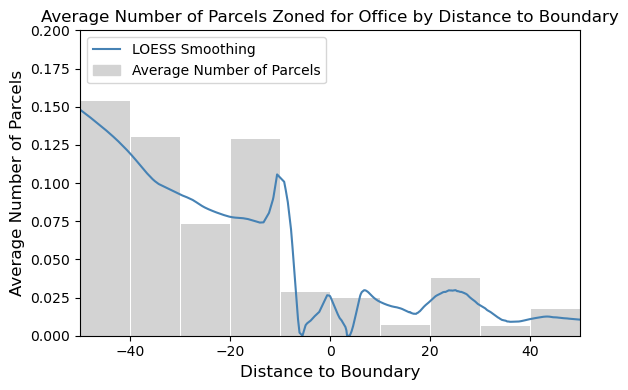

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from matplotlib.patches import Patch 
from matplotlib.lines import Line2D

# Preparing the data
df = boundary_homes[(np.absolute(boundary_homes['dist_to_boundary']) <= 75)].copy()
bin_edges = np.linspace(df['dist_to_boundary'].min(), df['dist_to_boundary'].max(), 11)
df['dist_to_boundary_bin'] = pd.cut(df['dist_to_boundary'], bins=bin_edges, include_lowest=True, precision=0)

# Grouping data
grouped_df = df.groupby('dist_to_boundary_bin').apply(lambda x: x['zp_OfficeComm'].mean()).reset_index()

# Prepare data for LOESS
x = df['dist_to_boundary'].values
y = df['zp_OfficeComm'].astype(int).values

# Fit LOESS model
lowess_results = sm.nonparametric.lowess(y, x, frac=0.25, it=0, delta=.05) 

# Generate new data for predictions
lower_bound = -50
upper_bound = 50
x_pred = np.linspace(0, upper_bound, 100)

# Calculate mean value for each bucket
bucket_width = 10
buckets = np.arange(lower_bound, upper_bound, bucket_width)
mean_values_per_bucket = [df[(df['dist_to_boundary'] >= left) & 
                             (df['dist_to_boundary'] < left + bucket_width)]['zp_OfficeComm'].mean() 
                          for left in buckets]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lowess_results[:, 0], 
         np.maximum(lowess_results[:, 1], np.zeros_like(lowess_results[:, 1].flatten())), 
         label='Predicted probabilities', color='steelblue')

# Add vertical bars
for i, left in enumerate(buckets):
    mean_val = mean_values_per_bucket[i]
    if mean_val is not np.nan:
        plt.bar(left + 5.1, mean_val, facecolor='lightgrey', width=bucket_width * .98)

# Legend
plt.legend(handles=[Line2D([0], [0], linestyle='-', color='steelblue', 
                           label='LOESS Smoothing', markersize=10),
                    Patch(color='lightgrey', label='Average Number of Parcels')], loc='upper left')

# Labels and Title
plt.xlabel('Distance to Boundary', fontsize=12)
plt.xlim((-50, 50))
plt.ylim((0, .2))
plt.ylabel('Average Number of Parcels', fontsize=12)
plt.title('Average Number of Parcels Zoned for Office by Distance to Boundary')

# Save the plot
plt.tight_layout()
plt.savefig('office_zoning_boundary.png', bbox_inches='tight')

# Show the plot
plt.show()


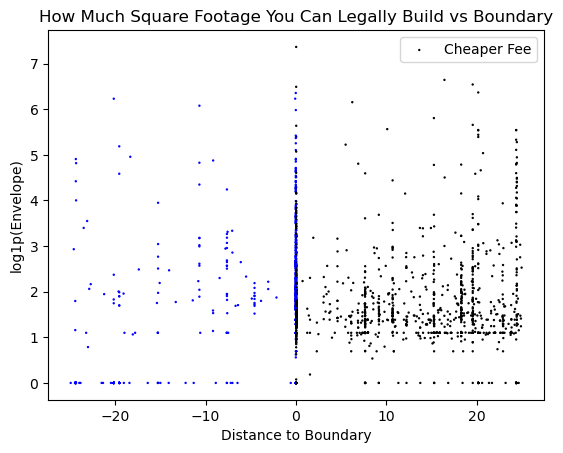

In [90]:
df = boundary_homes[(np.absolute(boundary_homes['dist_to_boundary']) <= 25)].copy()

plt.scatter(df['dist_to_boundary'],
            np.log1p(df['Envelope_1000']), alpha=1, s=.5,
            c=df['tier'].map({'tier1': 'black', 'tier2': 'blue'}))
plt.legend(['Cheaper Fee', 'Expensive Fee'])
plt.title('How Much Square Footage You Can Legally Build vs Boundary')
plt.xlabel('Distance to Boundary')
plt.ylabel('log1p(Envelope)')
plt.savefig('Envelope_boundary.png')

In [91]:
boundary_homes

,MapBlkLot_Master,Developed,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,Envelope_1000,Upzone_Ratio,zp_OfficeComm,zp_DensRestMulti,...,permit_6,permit_7,permit_8,Net_Units_Completed,tier1,tier2,tier,dist_to_tier1,dist_to_tier2,dist_to_boundary
87,3597006,False,0,1,89.916255,91.18226,5.999990,1.142855,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,27.196881,27.196881
88,3596125,False,1,1,89.916255,91.18226,2.000000,0.467071,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,155.949749,155.949749
89,3594037A,False,0,1,89.916255,91.18226,1.000000,1.175088,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,118.301736,118.301736
90,3594043,False,0,1,89.916255,91.18226,1.000000,0.157381,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,71.050029,71.050029
91,3594037,False,0,1,89.916255,91.18226,1.000000,0.751880,0,0,...,0.0,0.0,3.0,0.0,True,False,tier1,0.0,118.064955,118.064955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14498,6530010,False,1,1,89.916255,91.18226,6.185773,2.400000,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,47.076772,47.076772
14499,6532028,False,1,1,89.916255,91.18226,3.000000,1.176471,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,152.130542,152.130542
14501,6532034,False,1,1,89.916255,91.18226,3.564014,1.523083,0,1,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,46.565265,46.565265
14502,6532039,False,0,1,89.916255,91.18226,2.944018,2.000000,0,0,...,0.0,0.0,0.0,0.0,True,False,tier1,0.0,106.726141,106.726141


## Control for compounding treatments re: commercial

In [92]:
fees = gpd.read_file('../data/Neighborhood-Specific Impact Fee Areas.geojson')

In [93]:
fees = fees.to_crs(boundary_homes.crs)

In [94]:
higher_commercial_fee = fees[fees.tier.str.contains('Tier 1 if residential, 2 if non-residential') | False]

In [95]:
highest_commercial_fee = fees[fees.tier.str.contains('Tier 1 if residential, 3 if non-residential') | False]

In [97]:
boundary_homes['higher_commercial_fee'] = boundary_homes.geometry.intersects(higher_commercial_fee.geometry.values[0])

In [98]:
boundary_homes['highest_commercial_fee'] = boundary_homes.geometry.intersects(highest_commercial_fee.geometry.values[0])

<Axes: >

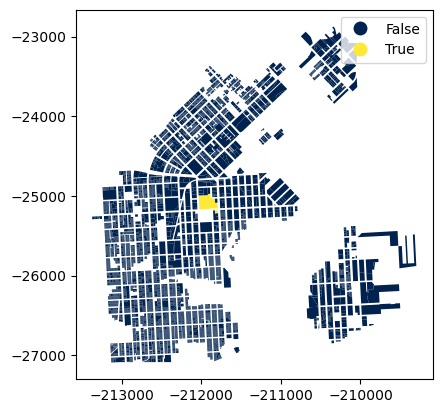

In [70]:
boundary_homes.plot(column='highest_commercial_fee', legend=True, cmap='cividis')

## Permits

In [71]:
boundary_homes.to_feather('../data/clean_fees_rdd.feather')

In [99]:
boundary_homes.to_csv('../data/clean_fees_rdd.csv')

## Confirm upzonings can be controlled for by 2010

In [ ]:
upzonings = parcels.pivot(index='MapBlkLot_Master', columns='year', values='Upzone_Ratio')
upzonings = upzonings.diff(axis=1).iloc[:, 1:-1]

In [ ]:
plot_upzoning = pd.merge(allParcels[['mapblklot', 'geometry']].drop_duplicates(),
                         upzonings,
                         right_index=True, 
                         left_on='mapblklot')

In [ ]:
simplefees = simplefees.to_crs(3857)
min_x, min_y, max_x, max_y = simplefees.total_bounds

In [ ]:
plot_upzoning = plot_upzoning.to_crs(3857)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
year = 2010
plot_upzoning[['geometry', year]][plot_upzoning[year] > 0].plot(ax=ax, column=year, legend=True)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False)

In [ ]:
plot_upzoning['tier1'] = plot_upzoning.geometry.intersects(simplefees.iloc[0].geometry)
plot_upzoning['tier2'] = plot_upzoning.geometry.intersects(simplefees.iloc[1].geometry)

In [ ]:
eastern_upzonings = plot_upzoning[plot_upzoning.tier1 | plot_upzoning.tier2]

In [ ]:
eastern_upzonings

In [ ]:
drop_nan = eastern_upzonings[~eastern_upzonings.isna().any(axis=1)]

In [ ]:
corr_coefficient, p_value = stats.spearmanr(drop_nan[2010], drop_nan['tier2'])
corr_coefficient

In [ ]:
corr_coefficient, p_value = stats.spearmanr(drop_nan[2011], drop_nan['tier2'])
corr_coefficient